In [10]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from IPython import display
display.set_matplotlib_formats("svg")
from torch.utils.data import DataLoader, TensorDataset

C:\Users\Admin\AppData\Local\Temp\ipykernel_8456\1930260902.py:8: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  display.set_matplotlib_formats("svg")


In [11]:
# import dataset from seaborn
import seaborn as sns
iris = sns.load_dataset("iris")

# organize the data

# convert from pandas dataframe to tensor
data = torch.tensor(iris[iris.columns[0:4]].values).float()

# transform species to number
labels = torch.zeros(len(data), dtype = torch.long)
# labels[iris.species == "setosa"] = 0 # don't need
labels[iris.species == "versicolor"] = 1
labels[iris.species == "virginica"] = 2

labels

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2])

In [12]:
train_data, test_data, train_labels, test_labels = train_test_split(data, labels, test_size = .2)

# then convert them into PyTorch Datasets (note: already converted to tensors)
train_data = TensorDataset(train_data, train_labels)
test_data = TensorDataset(test_data, test_labels)

# finally translate into dataloader objects
batchsize = 16
train_loader = DataLoader(train_data, shuffle = True, batch_size = batchsize)
test_loader = DataLoader(test_data, batch_size = test_data.tensors[0].shape[0]) # this is not split up and batch size = 1

In [13]:
class theModelClass(nn.Module):
    def __init__(self, dropoutRate):
        super().__init__()

        # layers
        self.input = nn.Linear(4, 12)
        self.hidden = nn.Linear(12, 12)
        self.output = nn.Linear(12, 3)

        # parameters
        self.dr = dropoutRate

    # forward pass
    def forward(self, x):

        # pass the data thru te input layer
        x = F.relu(self.input(x))

        # dropout after input layer
        x = F.dropout(x, p = self.dr, training = self.training) # self.training is set to True when model is in train mode and it is set to false when model is in eval mode

        # pass the data thru the hidden layer
        x = F.relu(self.hidden(x))

        # dropout after hidden layer
        x = F.dropout(x, p = self.dr, training = self.training)

        # output layer
        x = self.output(x)
        # nodropout here

        return x

In [14]:
# test the model
tmpnet = theModelClass(.25)

# run thru some random data
tmpdata = torch.randn((10, 4))
yhat = tmpnet(tmpdata)
yhat

tensor([[ 0.2124, -0.0409,  0.3732],
        [ 0.1980, -0.0582,  0.4282],
        [ 0.2166,  0.0467,  0.2826],
        [ 0.3055, -0.1159,  0.4423],
        [ 0.2818,  0.0451,  0.5125],
        [ 0.1644,  0.0130,  0.3515],
        [ 0.2108, -0.0478,  0.3884],
        [ 0.2407, -0.0975,  0.4200],
        [ 0.3620, -0.0035,  0.4496],
        [ 0.1640,  0.0829,  0.2972]], grad_fn=<AddmmBackward0>)

In [15]:
def createANewModel(dropoutrate):
    # grab an instance of the model class
    ANNiris = theModelClass(dropoutrate)

    # loss function
    lossfun = nn.CrossEntropyLoss()

    # optimizer
    optimizer = torch.optim.SGD(ANNiris.parameters(), lr = .002)

    return ANNiris, lossfun, optimizer

In [16]:
# train the model

# training parameter
numepochs = 500

def trainTheModel():
    trainAcc = []
    testAcc = []
    
    # train the model
    for epochi in range(numepochs):

        # switch training mode on
        ANNiris.train()

        # loop over training data batches
        batchAcc = []
        for X, y in train_loader:

            # forward pass and loss
            yHat = ANNiris(X)
            loss = lossfun(yHat, y)

            # backprop
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # compute training accuracy just for this batch
            batchAcc.append(100 * torch.mean((torch.argmax(yHat, axis = 1) == y).float()).item())

        # now that we've trained through the batches, get avg training accuracy
        trainAcc.append(np.mean(batchAcc))

        # test accuracy
        ANNiris.eval() # switch training off
        X, y = next(iter(test_loader))  # extract X, y from test dataloader
        predlabels = torch.argmax(ANNiris(X), axis = 1)
        testAcc.append(100 * torch.mean((predlabels == y).float()).item())

    # function output
    return trainAcc, testAcc

In [18]:
# create a model
dropoutrate = .0
ANNiris, lossfun, optimizer = createANewModel(dropoutrate)

# train the model
trainAcc, testAcc = trainTheModel()

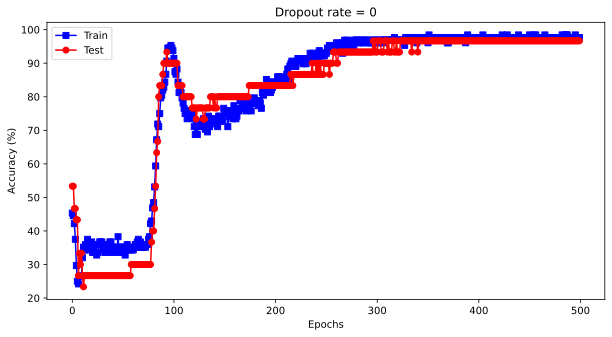

In [20]:
# plot the results
fig = plt.figure(figsize = (10, 5))

plt.plot(trainAcc, "bs-")
plt.plot(testAcc, "ro-")
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.legend(["Train", "Test"])
plt.title("Dropout rate = %g" %dropoutrate)

plt.show()

In [21]:
# run an experiment

dropoutRates = np.arange(10)/10
results = np.zeros((len(dropoutRates), 2))

for di in range(len(dropoutRates)):

    # create and train model
    ANNiris, lossfun, optimizer = createANewModel(dropoutRates[di])
    trainAcc, testAcc = trainTheModel()

    # store the accuracies from last 100 epochs
    results[di, 0] = np.mean(trainAcc[-50:])
    results[di, 1] = np.mean(testAcc[-50:])

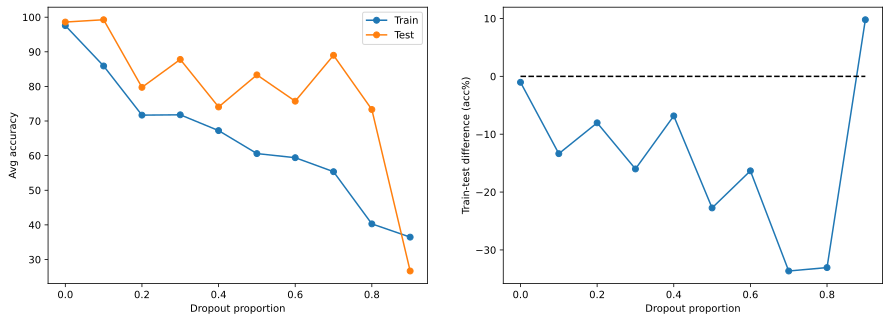

In [22]:
# plot the experiment results
fig, ax = plt.subplots(1, 2, figsize = (15, 5))

ax[0].plot(dropoutRates, results, "o-")
ax[0].set_xlabel("Dropout proportion")
ax[0].set_ylabel("Avg accuracy")
ax[0].legend(["Train", "Test"])

ax[1].plot(dropoutRates, -np.diff(results, axis = 1), "o-")
ax[1].plot([0, .9], [0, 0], "k--")
ax[1].set_xlabel("Dropout proportion")
ax[1].set_ylabel("Train-test difference (acc%)")

plt.show()